In [754]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import warnings
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# This project will look at passwords, and utilize natural language processing (NLP) to classify whether they are weak, ok, or strong.

In [755]:
import sqlite3
conn = sqlite3.connect('password_data.sqlite')

## - Let's connect to the database and read the data

In [756]:
data = pd.read_sql_query('SELECT * FROM Users', con=conn)

In [757]:
data

,index,password,strength
0,0,zxe870819,1
1,1,xw46454nr23l,1
2,2,soporte13,1
3,3,accounts6000webhost.com,2
4,4,c443balg,1
...,...,...,...
99995,99995,obejofi215,1
99996,99996,fmiopvxb64,1
99997,99997,czvrbun38,1
99998,99998,mymyxe430,1


## * Part 1 - Cleaning

In [758]:
data.drop(['index'], axis=1, inplace=True)

In [759]:
data

,password,strength
0,zxe870819,1
1,xw46454nr23l,1
2,soporte13,1
3,accounts6000webhost.com,2
4,c443balg,1
...,...,...
99995,obejofi215,1
99996,fmiopvxb64,1
99997,czvrbun38,1
99998,mymyxe430,1


In [760]:
data.duplicated().sum()

0

In [761]:
data.isnull().sum()

password    0
strength    0
dtype: int64

In [762]:
data.dtypes

password    object
strength     int64
dtype: object

## * Part 2 - Analysis

## - All of the passwords are stored as strings, so I'll look to use some methods to better represent them.  I will be looking at what type of charectars are used, whether they are upper case or lower, and the frequency.

In [763]:
data[data['password'].str.isnumeric()]

,password,strength
12280,943801,0
14992,12345,0
20958,147856,0
21671,140290,0
23269,123987,0
28569,1233214,0
31329,0159456,0
32574,363761,0
37855,4524344,0
43648,5521597,0


In [764]:
data[data['password'].str.isnumeric()].shape

(26, 2)

### 26 user passwords are numerical only

In [765]:
data[data['password'].str.isalpha()]

,password,strength
267,PomarancaÇ,1
1380,smgodt,0
3198,cuado,0
4560,jelsz,0
6380,demsxp,0
7803,secret,0
9218,caballo,0
11555,mhe,0
11667,kreedo,0
13645,nõmlich,0


In [766]:
data[data['password'].str.isalpha()].shape

(50, 2)

### 50 user passwords are lower alphabetical only

In [767]:
data[data['password'].str.istitle()]

,password,strength
64,Hisanthoshjasika0,2
242,Therockrockbottom72,2
338,1A2S3D4F,1
367,13269123A,1
526,Csicskarozsika1,2
...,...,...
99168,1053815198M,1
99192,Alfranx05122023,2
99375,Kensington1956,2
99590,V13000993J,1


In [768]:
data[data['password'].str.istitle()].shape

(932, 2)

### 932 passwords first letter is capital

In [769]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [770]:
def find_special(row):
    for char in row:
        if char in string.punctuation:
            return 1
        else:
            pass

In [771]:
data['password'].apply(find_special)==1

0        False
1        False
2        False
3         True
4        False
         ...  
99995    False
99996    False
99997    False
99998    False
99999    False
Name: password, Length: 100000, dtype: bool

In [772]:
data[data['password'].apply(find_special)==1]

,password,strength
3,accounts6000webhost.com,2
68,12463773800+,1
98,p.r.c.d.g.,1
145,cita-cita,1
180,karolina.susnina0U,2
...,...,...
99748,maiselis.com,1
99845,hosting4meze!@#,2
99954,semista_bakung15,2
99980,halflife2010!LEB,2


### 2663 users have special charectars in their password

## * Part 3 - Feature Engineering

## - I'll now add new features that will be critical to developing my model.

In [773]:
data['length'] = data['password'].str.len()
data.head(4)

,password,strength,length
0,zxe870819,1,9
1,xw46454nr23l,1,12
2,soporte13,1,9
3,accounts6000webhost.com,2,23


In [774]:
def freq_lower(row):
    return len([char for char in row if char.islower()])/len(row)

In [775]:
def freq_upper(row):
    return len([char for char in row if char.isupper()])/len(row)

In [776]:
def freq_num(row):
    return len([char for char in row if char.isdigit()])/len(row)

In [777]:
data['lower_frequency'] = np.round(data['password'].apply(freq_lower),3)
data['upper_frequency'] = np.round(data['password'].apply(freq_upper),3)
data['digit_frequency'] = np.round(data['password'].apply(freq_num),3)

In [778]:
data.head(4)

,password,strength,length,lower_frequency,upper_frequency,digit_frequency
0,zxe870819,1,9,0.333,0.0,0.667
1,xw46454nr23l,1,12,0.417,0.0,0.583
2,soporte13,1,9,0.778,0.0,0.222
3,accounts6000webhost.com,2,23,0.783,0.0,0.174


In [779]:
def freq_special(row):
    special_chars = []
    for char in row:
        if not char.isalpha() and not char.isdigit():
            special_chars.append(char)
    return len(special_chars)

In [780]:
data['special_char_frequency'] = np.round(data['password'].apply(freq_special),3)

In [781]:
data.head(5)

,password,strength,length,lower_frequency,upper_frequency,digit_frequency,special_char_frequency
0,zxe870819,1,9,0.333,0.0,0.667,0
1,xw46454nr23l,1,12,0.417,0.0,0.583,0
2,soporte13,1,9,0.778,0.0,0.222,0
3,accounts6000webhost.com,2,23,0.783,0.0,0.174,1
4,c443balg,1,8,0.625,0.0,0.375,0


In [782]:
data['special_char_frequency'] = data['special_char_frequency']/data['length']

In [783]:
data.head(4)

,password,strength,length,lower_frequency,upper_frequency,digit_frequency,special_char_frequency
0,zxe870819,1,9,0.333,0.0,0.667,0.000000
1,xw46454nr23l,1,12,0.417,0.0,0.583,0.000000
2,soporte13,1,9,0.778,0.0,0.222,0.000000
3,accounts6000webhost.com,2,23,0.783,0.0,0.174,0.043478


## * Part 4 - Analysis to understand importance of features

### - By doing some simple statistical analysis, we can gain insight into how important each feature is to strength

In [784]:
cols = ['length', 'lower_frequency', 'upper_frequency', 'digit_frequency', 'special_char_frequency']
for col in cols:
    print(col)
    print(data[[col, 'strength']].groupby(['strength']).agg(['min', 'max', 'mean', 'median']))
    print('\n')

length
         length                       
            min  max       mean median
strength                              
0             1    7   6.550947    7.0
1             8   13   9.611074    9.0
2            14  220  15.953421   16.0


lower_frequency
         lower_frequency                        
                     min    max      mean median
strength                                        
0                    0.0  1.000  0.708050  0.714
1                    0.0  0.923  0.630067  0.667
2                    0.0  0.917  0.424679  0.400


upper_frequency
         upper_frequency                        
                     min    max      mean median
strength                                        
0                    0.0  1.000  0.012872  0.000
1                    0.0  0.923  0.007915  0.000
2                    0.0  0.889  0.367633  0.429


digit_frequency
         digit_frequency                        
                     min    max      mean median
strength           

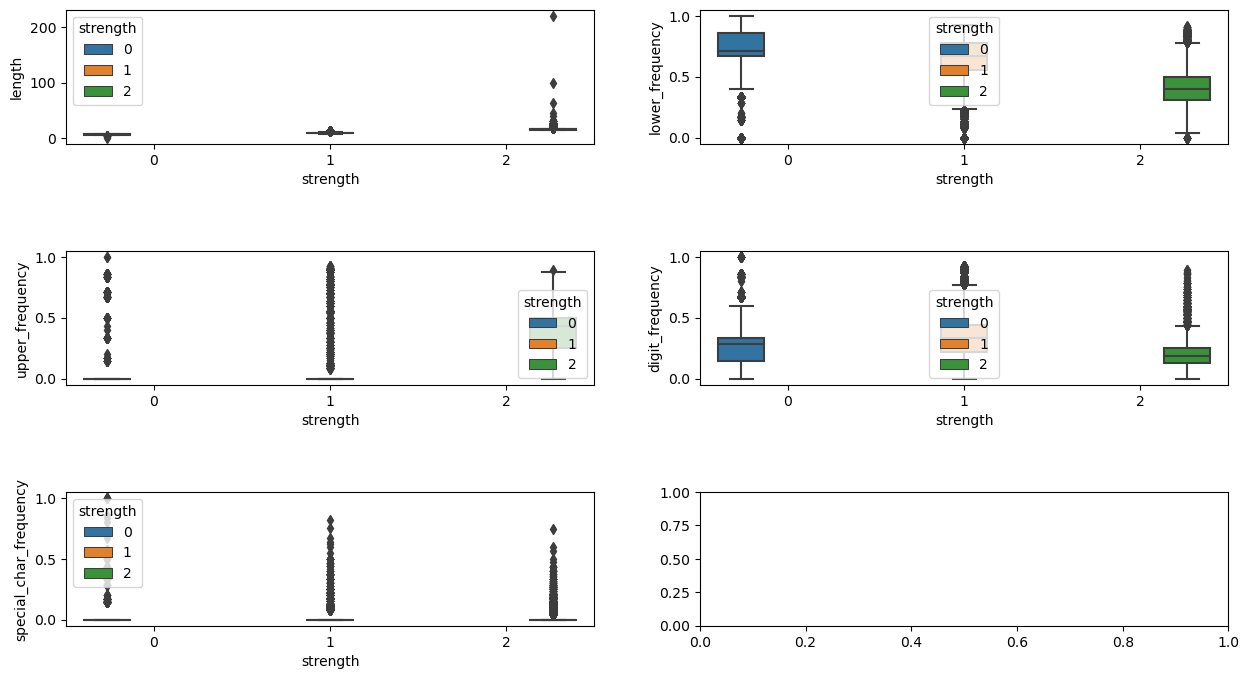

In [785]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(15,8))

sns.boxplot(x='strength', y= 'length' , hue='strength', ax=ax1, data=data)
sns.boxplot(x='strength', y= 'lower_frequency', hue='strength', ax=ax2, data=data)
sns.boxplot(x='strength', y= 'upper_frequency', hue='strength', ax=ax3, data=data)
sns.boxplot(x='strength', y= 'digit_frequency', hue='strength', ax=ax4, data=data)
sns.boxplot(x='strength', y= 'special_char_frequency', hue='strength', ax=ax5, data=data)

plt.subplots_adjust(hspace=0.8)

## - Here I can notice that length strongly correlates with strength.  In general the longer the password is, the more of a chance it has to include special chars, as well as a mix of lower and upper chars.

## * Part 5 - Applying feature importance

### - For this section, I will be analyzing the relationship between length and strength

In [786]:
def get_dist(data, feature):
    plt.subplot(1,2,1)
    sns.violinplot(x='strength', y=feature, data=data)
    plt.subplot(1,2,2)
    
    sns.distplot(data[data['strength']==0][feature], color='red', label='0', hist=False)
    sns.distplot(data[data['strength']==1][feature], color='orange', label='1', hist=False)
    sns.distplot(data[data['strength']==2][feature], color='yellow', label='2', hist=False)
    plt.legend()
    plt.show()

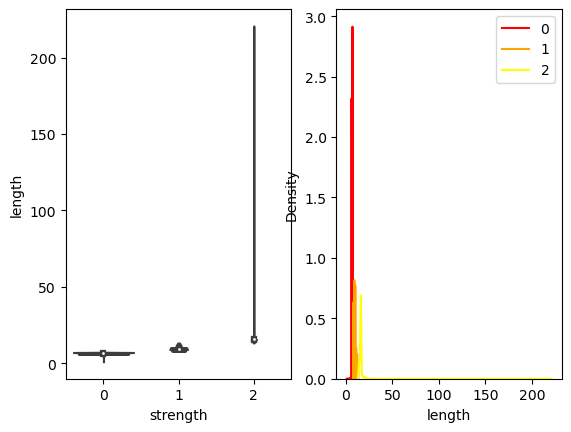

In [787]:
get_dist(data, 'length')

### - Another feature worth considering would be lowercase frequency

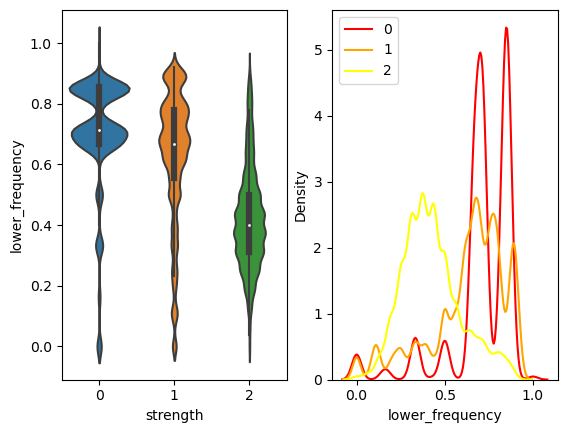

In [788]:
get_dist(data, 'lower_frequency')

## - Let's also compare strength and digit frequency data in the same sense

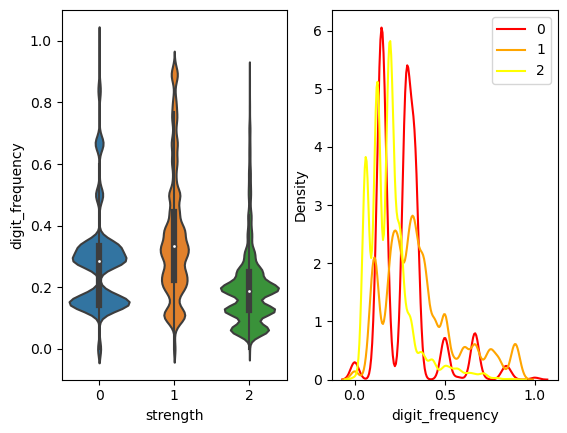

In [789]:
get_dist(data, 'digit_frequency')

### - It is shown here that stronger passwords generally have a smaller frequency of lowercase letters compared to weaker passwords, while digit frequency doesn't make much of a difference.

## * Part 6 - Now I'll utilize NLP techniques to turn our password's text into a mathematical representation and prepare the data.

In [790]:
data.head(5)

,password,strength,length,lower_frequency,upper_frequency,digit_frequency,special_char_frequency
0,zxe870819,1,9,0.333,0.0,0.667,0.000000
1,xw46454nr23l,1,12,0.417,0.0,0.583,0.000000
2,soporte13,1,9,0.778,0.0,0.222,0.000000
3,accounts6000webhost.com,2,23,0.783,0.0,0.174,0.043478
4,c443balg,1,8,0.625,0.0,0.375,0.000000


In [791]:
df1 = data.sample(frac=1)

In [792]:
df1

,password,strength,length,lower_frequency,upper_frequency,digit_frequency,special_char_frequency
5524,d3ndr4456,1,9,0.444,0.000,0.556,0.0
64625,mw159357,1,8,0.250,0.000,0.750,0.0
1365,bd5aidi,0,7,0.857,0.000,0.143,0.0
4446,kijangd1738dt,1,13,0.692,0.000,0.308,0.0
54053,MVsaEZjg2OQCWC7P,2,16,0.250,0.625,0.125,0.0
...,...,...,...,...,...,...,...
10775,zitizi260,1,9,0.667,0.000,0.333,0.0
34966,identity14THIEF,2,15,0.533,0.333,0.133,0.0
94177,a106020141,1,10,0.100,0.000,0.900,0.0
90112,is2971md,1,8,0.500,0.000,0.500,0.0


In [793]:
vector = TfidfVectorizer(analyzer='char')

In [794]:
x = list(df1['password'])

In [795]:
X = vector.fit_transform(x)
X

<100000x99 sparse matrix of type '<class 'numpy.float64'>'
	with 842571 stored elements in Compressed Sparse Row format>

In [796]:
X.shape

(100000, 99)

In [797]:
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [798]:
df2 = pd.DataFrame(X.toarray(), columns=vector.get_feature_names_out())

In [799]:
df2

,,,,,,,,,!,#,...,ñ,ó,õ,ö,÷,ú,ü,ý,þ,›
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## * Part 7 - Building my model

In [800]:
df2['length'] = data['length']
df2['lower_frequency'] = data['lower_frequency']
df2

,,,,,,,,,!,#,...,õ,ö,÷,ú,ü,ý,þ,›,length,lower_frequency
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0.333
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,0.417
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0.778
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23,0.783
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,0.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,0.700
99996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,0.800
99997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0.778
99998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0.667


## - From this dataframe, we will extract our testing & training data

In [801]:
y = data['strength']
X_train, X_test, y_train, y_test = train_test_split(df2,y, test_size=0.20)

In [802]:
X_train.shape

(80000, 101)

## - Using 80% of my data for training, and the rest for testing

In [803]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(multi_class='multinomial')

In [804]:
clf.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

In [805]:
pred = clf.predict(X_test)

In [806]:
pred

array([1, 1, 1, ..., 2, 1, 1])

In [807]:
Counter(pred)

Counter({1: 14716, 0: 2764, 2: 2520})

## * Part 7 - I'll now test it on sample data

In [808]:
pass1 = 'snfkl5#2'

In [809]:
sample1 = np.array([pass1])

In [810]:
matrix1 = vector.transform(sample1)

In [811]:
len(pass1)

8

In [812]:
[char for char in pass1 if char.islower()]

['s', 'n', 'f', 'k', 'l']

In [813]:
len([char for char in pass1 if char.islower()])/len(pass1)

0.625

In [814]:
np.append(matrix1.toarray(), (8,.625)).shape

(101,)

In [815]:
np.append(matrix1.toarray(), (8,.625)).reshape(1,101)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75213254,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.20419965, 0.        , 0.        ,
        0.25566088, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.31066149, 0.        , 0.        ,
        0.        , 0.        , 0.26320318, 0.24510661, 0.        ,
        0.21850776, 0.        , 0.        , 0.        , 0.        ,
        0.23157568, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [816]:
new1 = np.append(matrix1.toarray(), (11,.27)).reshape(1,101)

In [817]:
clf.predict(new1)

array([1])

## - My model predicted my password of 'snfk15#2' to be 'okay'.  I'll automate the process to for easier testing.

In [818]:
def predict():
    pass2 = input('Enter a password: ')
    sample = np.array([pass2])
    matrix = vector.transform(sample)
    
    length_pass = len(pass2)
    length_normalized = len([char for char in pass2 if char.islower()])/len(pass2)
    
    new_matrix = np.append(matrix.toarray(), (length_pass, length_normalized)).reshape(1,101)
    
    result = clf.predict(new_matrix)
    
    if result == 0:
        return 'Password is weak'
    elif result ==1:
        return 'Password is okay'
    else:
        return 'Password is strong'

In [819]:
predict()

Enter a password: kdn34


'Password is weak'

In [820]:
predict()

Enter a password: fjknd$#eaR


'Password is okay'

In [821]:
predict()

Enter a password: Fo0R8#4nfklE2n


'Password is strong'